# LANL Earthquakes Competition: why do spectrograms fail?

## Summary

As I went over the first lectures of FastAI Deep-Learning course, and as I've previously encountered the [use of Convolutional NN for analysis of spectrograms of audio signals](https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89), I decided to apply this approach on the [LANL earthquakes competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction/overview).

Several people already referred to this approach in the context of the LANL competition (e.g. [[1](https://www.kaggle.com/michael422/spectrogram-convolution)],[[2](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/91776#latest-529254)]), but I did not notice any successful reported results (which of course may simply indicate my ignorance).

**I didn't manage to build any impressive spectrogram-based model either, and I'd like to try to shed some light on the reasons, focusing on mel-spectrograms which are based on librosa library.**

**In short, it seems that librosa applies by default certain manipulations on the spectrograms (e.g. choice of frequency-scaling and power-scaling), which might have made sense for audio classification, but are apparently less relevant to the LANL competition.**

**Tuning librosa's spectrogram methods to correspond to LANL dataset seems quite tricky, thus I believe that any attempt of spectrograms in the scope of the competition would benefit from avoiding such general audio tools - unless the user knows exactly how these tools work and why.**

**Of course, it is not guaranteed that spectrogram-based models have any significant potential in this competition at all. I'd be gald to hear any observations and thoughts regarding this issue.**

For whoever interested in the librosa-based spectrograms nonetheless, there's a piece of code at the bottom of this notebook that generates and saves them as PNG files.

## Initialization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
import librosa
import librosa.display

In [3]:
BASE = Path('../Data')

## Mel-spectrogram tuning

Following several resources (e.g. [this one](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52)), I decided to **use librosa library** to generate the images.

After several attempts, I decided (according to my judgement of the images' visuality, see below) to go with **log-scaled frequencies and log-scaled powers**.
Following the same references mentioned above, I decided to do so through librosa's **mel-spectrograms**.
The main steps are simply applying *librosa.feature.melspectrogram()*, *librosa.amplitude_to_db()* and *librosa.display.specshow()* sequentially on the input signal.

In [4]:
# Load some data segments

def get_segment(skiprows=None, samples_per_segment = 150000):
    df = pd.read_csv(BASE/'train.csv', nrows=samples_per_segment, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
    df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    return df


df = get_segment()
df2 = get_segment(range(1,int(2.2e6)))
df_peak = get_segment(range(1,int(4.4e6)))

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


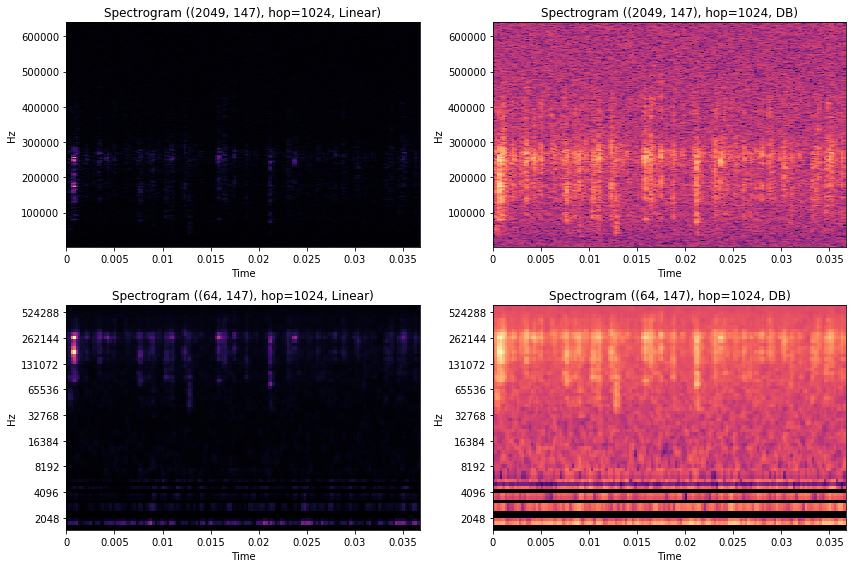

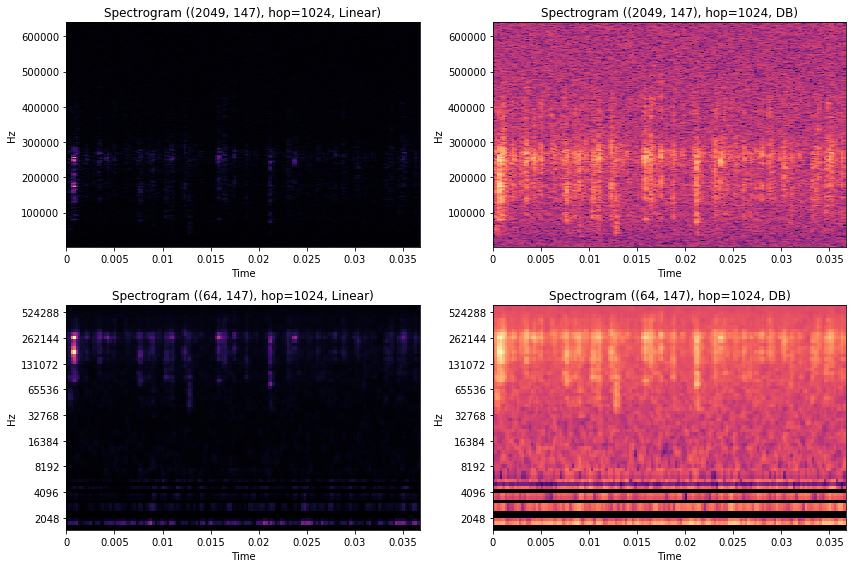

In [5]:
def plot_spec(df, n_fft=4096, hop_length=1024, sr=4096e3, n_mels=64, fmin=1480, fmax=640e3):
    stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)

    fig,axs = plt.subplots(2,2, figsize=(12,8))
    librosa.display.specshow(stft_magnitude, ax=axs[0,0], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,0].set_ylim((fmin,fmax))
    axs[0,0].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, Linear)')

    librosa.display.specshow(stft_magnitude_db, ax=axs[0,1], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,1].set_ylim((fmin,fmax))
    axs[0,1].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, DB)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    librosa.display.specshow(mel_spec, ax=axs[1,0], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,0].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, Linear)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec, ax=axs[1,1], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,1].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, DB)')
    
    plt.tight_layout()

plot_spec(df)
plot_spec(df_peak)

Unfirtunately, the pretty logarithmic spectrograms suffered from **annoying black rows in their images**.

It turns out that mel-spectrograms essentially sample the FFT of the signal on multiple bands of frequencies (***filter banks***), which become exponentially-wider in large frequencies. In addition, **the banks of mel-spectrograms use [universally-conventional values](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)**, which were probably chosen for applications of humanly-heardable audio sounds, apparently unlike the frequencies of a simulated earthquakethe.
The frequencies mis-match resulted in empty frequency-banks which were represented as black rows in the images.

As a result, I had to either change the whole banks scale (which I didn't easily find a trivial way to do through librosa library) or use fictive sample rate. I chose the latter, and instead of the true sample rate of ~4MHz, I fed librosa (using again my special visual judgment skills) with a fictive sample rate of 44KHz.

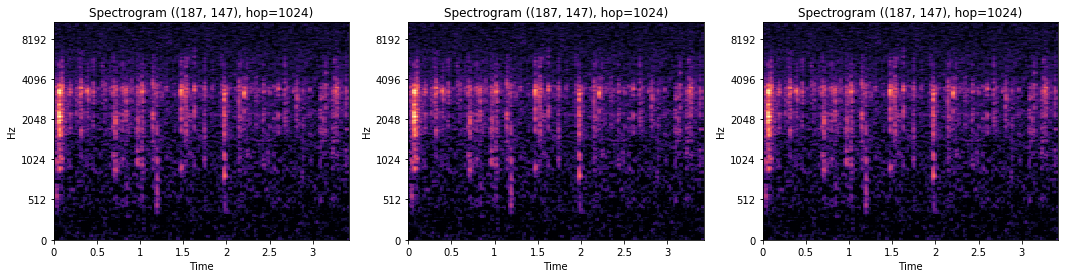

In [6]:
def plot_spec(dfs, n_fft=4096, hop_length=None, sr=44e3, n_mels=256, fmin=0, fmax=128e3, power=2.0, lin=False):
    if hop_length is None:
        hop_length = n_fft // 4
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
        l = mel_spec.shape[0]
        mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', 
                                 sr=sr, hop_length=hop_length)#, fmin=fmin, fmax=fmax)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
        
        if lin:
            ax = axs[1,i]
            stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax, x_axis='time', y_axis='linear', 
                                     sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
            ax.set_ylim((fmin,fmax))
            ax.set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d})')


plot_spec((df,df2,df_peak), sr=44e3, n_fft=4096, n_mels=256, power=2.0)

This time, the problem was **similar scale of colors for all the spectrograms, despite of significant differences in the powers of the underlying signals**, which should carry important imformation regarding the desired time-to-failure (which is the number we need to predict in the competition).

After going through the code, I found out that
1. I used amplitude_to_db(..., ref=np.max), which chooses the DB scale according to the maximum of the current signal's FFT, hence I lost most of the differentiation between segments' scales.
2. I used plt.imsave(filename, image) which uses an input array image instead of plt.savefig(filename) which uses the current open figure, hence I totally ignored the plotting function specshow().

I tried to choose a constant reference to the DB scale, plot nicely-looking spectrograms with specshow(), and save them correctly with savefig().
**I did receive a much more variat color scale** (see below), and I did recieve (over 20 randomly chosen segments) a **quite monotonous (though apparently not continuous) relation between the power of the signal and the power of the colors** in the first channel of spectrogram.

In [15]:
from scipy.misc import imread
seg_len = int(150e3)
n_fft=4096
hop_length=1024
sr=44e3
n_mels=256
power=2.0
class_limits=(0,1,2,3,4,5,6,7,8,10,12,99)

In [23]:
# Get 20 random segments + a peak segment, generate their spectrogram-arrays and PNG files.

np.random.seed(0)
sigs = []
specs = []
mels = []
ims = []
hops = list(np.random.randint(0,6000,20)) + [int(4.4e6/hop_length)]
for hop in hops:
    # load signal
    tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                      nrows=seg_len, skiprows=range(1,1+hop*hop_length))
    tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    # extract signal
    sigs.append(tmp.signal.values)
    # generate spec
    mel_spec = librosa.feature.melspectrogram(np.array(tmp.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sr, power=power)
    specs.append(mel_spec)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
    l = mel_spec.shape[0]
    mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
    mels.append(mel_spec)
    # save as PNG and load image
    fig = plt.figure(figsize=(2.6,2.6))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    librosa.display.specshow(mel_spec, ax=plt.axes(), x_axis='time', y_axis='mel', vmin=-50, vmax=50,
                             sr=sr, hop_length=hop_length)
    plt.axes().set_axis_off()
    plt.savefig('tmp_spec.png')
    plt.close()
    ims.append(imread('tmp_spec.png'))

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


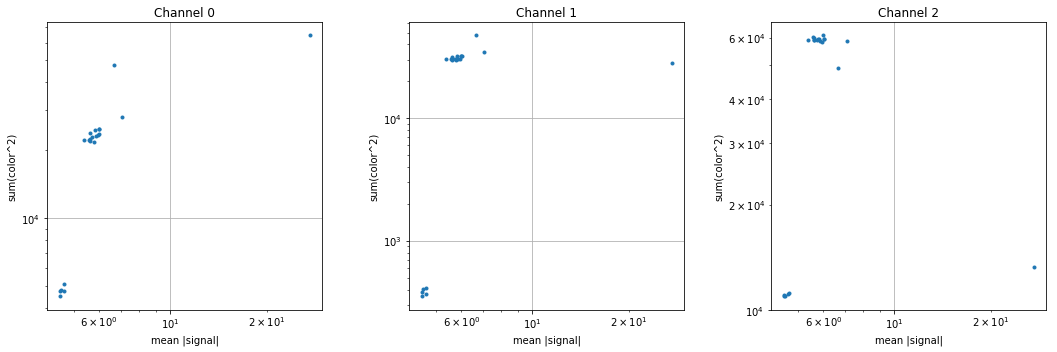

In [25]:
# Look for relation between the signal "power" (measured by mean(|signal|))
# and the PNG image color range (measured by sum(color^2) for each channel separately).

fig, axs = plt.subplots(1,3, figsize=(15,5))
for channel in range(3):
    axs[channel].plot([np.mean(np.abs(m.flatten())) for m in sigs],
                      [np.mean(([t**2 for t in im[:,:,channel].flatten()])) for im in ims],'.')
    axs[channel].set_xlabel('mean |signal|')
    axs[channel].set_ylabel('sum(color^2)')
    axs[channel].set_title(f'Channel {channel:d}')
    axs[channel].set_xscale('log')
    axs[channel].set_yscale('log')
    axs[channel].grid()
plt.tight_layout()

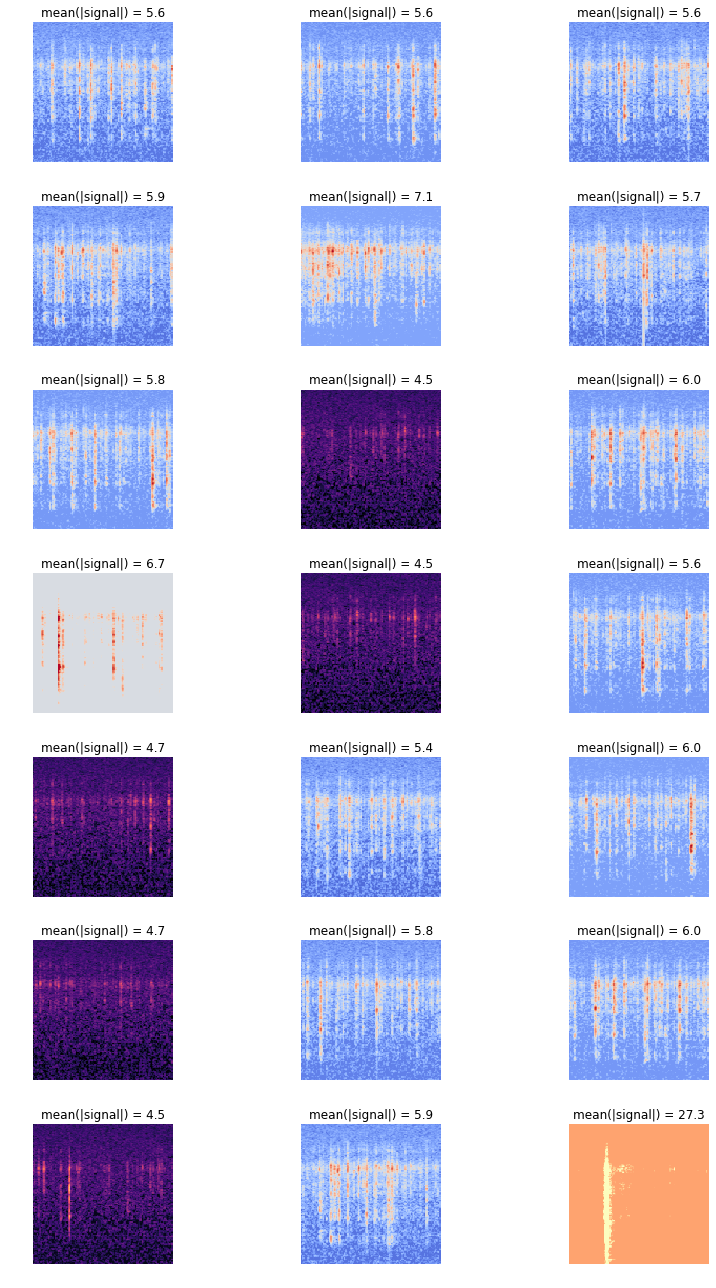

In [24]:
fig, axs = plt.subplots(7,3, figsize=(12,18))

for i,(s,im) in enumerate(zip(sigs,ims)):
    ax = axs[i%7,i//7]
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'mean(|signal|) = {np.mean(np.abs(s.flatten())):.1f}')

plt.tight_layout()

Unfortunately, all the efforts **did not yield much success in predicting the next earthquake**.

I tried to build a standard RESNET34 CNN using FastAI to predict the TTF of each segment using its spectrogram. The results on my Cross-Validation mechanism were quite bad, and I didn't bother applying the model on public test data to submit for LB (according to the empirically-known relation between my CV-score and the LB-score, I'd probably get around 1.6 on LB).

**In conclusion, it looks like blackbox-based spectrograms (e.g. the mel-spectrograms of librosa library) are quite tricky to use for the LANL dataset, since they apply manipulations on the signal which are often unwanted, and are not trivial to understand for the common user.**

**While it is not guaranteed that a spectrogram-based model can achieve good results on the LANL dataset, I'd focus any further attempts on manually-generated spectrograms, with careful tuning of scales of frequencies and powers.**

## Generate spectrograms data

If anyone still happens to be interested, the code below should generate a dataset of the latter variant of the spectrograms (as PNG files) - just make sure to adjust the paths below.

(took about 40 minutes on my laptop)

In [11]:
BASE = Path('../Data')
TRAIN = BASE/'train_spec3'

n_all = 629145480 # df_full.shape[0]
seg_len = int(150e3)
hop_len = int(25e3)
n_hops = int(n_all/hop_len)
segs_to_read = 1050
hops_to_read = int(segs_to_read * seg_len/hop_len)

In [12]:
def save_spec(df, seg_index, meta, class_limits=(0,1,2,3,4,5,6,7,8,10,12,99), base_path=TRAIN,
              n_fft=4096, hop_length=1024, sr=44e3, n_mels=256, power=2.0, fig=None):
    
    # get ttf and derive the filename
    tf = df.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(seg_index) + '_' + cls_nm + '.png'
    
    # compute spectrogram
    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
    l = mel_spec.shape[0]
    mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
    meta.loc[seg_index] = [fname, tf, cls_nm, np.mean(mel_spec), np.var(mel_spec)]
    
    # save as PNG
    if fig is None:
        fig = plt.figure(figsize=(2.6,2.6))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    librosa.display.specshow(mel_spec, ax=plt.axes(), x_axis='time', y_axis='mel', vmin=-50, vmax=50,
                             sr=sr, hop_length=hop_length)
    plt.axes().set_axis_off()
    plt.savefig(base_path/fname)
    plt.clf()

Read train data in 4 chunks of 1K segments;
save each segment's spectrogram (as png file);
and keep a table of segments and their quaketimes:

In [13]:
GENERATE_SPECTS = True

if GENERATE_SPECTS:
    meta = pd.DataFrame(columns=('filename','time','class'))
    fig = plt.figure(figsize=(2.6,2.6))
    for i in tqdm_notebook(range(n_hops)):
        if i % hops_to_read == 0:
            tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                              nrows=seg_len*(segs_to_read+1), skiprows=range(1,1+i*hop_len))
            tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
        save_spec(tmp[(i%hops_to_read)*hop_len:(i%hops_to_read)*hop_len+seg_len], i, meta, fig=fig)

    meta.to_csv(TRAIN/'train_spec_meta.csv', index=False)
else:
    meta = pd.read_csv(TRAIN/'train_spec_meta.csv')

,filename,time,class,fold
0,0_01-02.png,1.430797,01-02,3
1,1_01-02.png,1.424497,01-02,3
2,2_01-02.png,1.418096,01-02,3
3,3_01-02.png,1.411696,01-02,3
4,4_01-02.png,1.404200,01-02,3


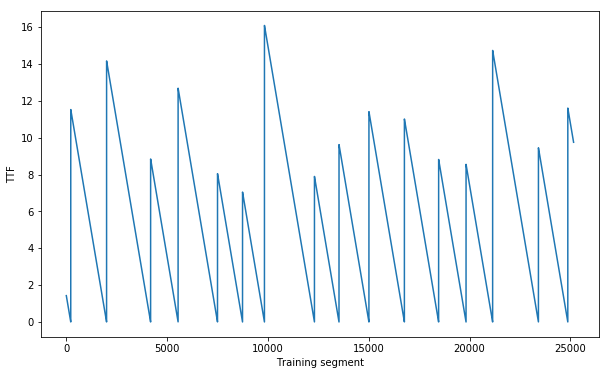

In [14]:
plt.figure(figsize=(10,6))
plt.plot(meta.time)
plt.xlabel('Training segment')
plt.ylabel('TTF')
meta.head()